In [934]:
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
from tqdm import tqdm 

In [935]:
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

In [936]:
param_name = "Theta_7"

with open(f'/home/chri6578/Documents/CES/params/{param_name}.pickle', 'rb') as file:
    Theta = pickle.load(file)
    
n = Theta['n']
Lambda = Theta['Lambda']
Eta = Theta['Eta']
Alpha = Theta['Alpha']
Beta = Theta['Beta']
Gamma = Theta['Gamma']
T = 1e4

In [937]:
np.mean(Lambda)

10.411853740917131

In [938]:
# step 2
PHI = {}

for i in range(n):
    PHI[i] = []
    t = 0
    t_prev = 0
    while t_prev < T:
        t = np.random.exponential(Lambda[i])[0]
        PHI[i].append(t + t_prev)
        t_prev = t + t_prev

In [939]:
np.sum([len(PHI[i]) for i in range(n)])

45047

In [940]:
# step 3
tuple_list = [(i, t) for i in range(n) for t in PHI[i]]
T_list = sorted(tuple_list, key=lambda x: x[1])

In [941]:
# steps 4-11

E_all = {}
for i in range(n):
    E_all[i] = []
t_last = np.zeros((n,))

bar_tau_0 = 5

for (e,t) in T_list:
    # update x_i^t
    s = np.sum( Gamma[e]*(t_last != 0)*(t_last < t)*(t_last > t - bar_tau_0) )
    # print(np.sum((t_last != 0)*(t_last < t)*(t_last > t - bar_tau_0)))
    p = sigmoid(s)
    # print(s, p)
    # trial = np.random.binomial(1,p)
    trial = p > 0.4999999999
    if trial:
        E_all[e].append(t)
        t_last[e] = t

In [942]:
# save PHI, and E_all

# load Theta, PHI, and E_all

In [943]:
# Estimating Probability of Causation 

tau_bar = 5

Pn = np.zeros((n,n))
Ps = np.zeros((n,n))
Pn2 = np.zeros((n,n))
Ps2 = np.zeros((n,n))
Pns = np.zeros((n,n))
Pns2 = np.zeros((n,n))

# think of this as Monte Carlo
for i in tqdm(range(n)):
    Pa_i = [k for k in  range(n) if Alpha[i][k] > 0 ]
    # print(Pa_i)
    # print(len(PHI[i]))
    for j in range(n):
        gPn = [] 
        gPs = []
        gPn2 = [] 
        gPs2 = [] 
        n_yz_ = 0
        n_y_z = 0
        for t in PHI[i]:
            # search for j in (t -tau_bar, t)
            Lij = [t_ for t_ in E_all[j] if t - tau_bar < t_ < t]
            if len(Lij) > 0:
                if t in E_all[i]:
                    # (y_i, z_j)
                    t_last = np.zeros((n,))
                    for k in Pa_i:
                        Lik = [t_ for t_ in E_all[k] if t - tau_bar < t_ < t]
                        if len(Lik)>0:
                            t_last[k] = np.max(Lik)
                            
                    t_last[j] = 0 # imposing z_j' 
                    
                    #calculate probability of necessity                    
                    gPn.append(
                        1 - (sigmoid( np.sum( Gamma[e]*(t_last != 0)*(t_last < t)*(t_last > t - bar_tau_0) )) > 0.499999 )
                    )
                    
                    # print(np.sum((t_last != 0)*(t_last < t)*(t_last > t - bar_tau_0)))
                
                else:
                    # (y_i', z_j)
                    n_y_z += 1
                    
                    t_last = np.zeros((n,))
                    for k in Pa_i:
                        Lik = [t_ for t_ in E_all[k] if t - tau_bar < t_ < t]
                        if len(Lik)>0:
                            t_last[k] = np.max(Lik)
                            
                    t_last[j] = 0 # imposing z_j' 
                    
                    #calculate probability of necessity                    
                    gPs2.append(
                        0 + (sigmoid( np.sum( Gamma[e]*(t_last != 0)*(t_last < t)*(t_last > t - bar_tau_0) )) > 0.499999 )
                    )
            
            else:
                if t not in E_all[i]:
                    # (y_i', z_j')
                    t_last = np.zeros((n,))
                    for k in Pa_i:
                        Lik = [t_ for t_ in E_all[k] if t - tau_bar < t_ < t]
                        if len(Lik)>0:
                            t_last[k] = np.max(Lik)
                            
                    t_last[j] = np.random.uniform(t- tau_bar, t) # imposing z_j 
                    
                    #calculate probability of necessity                    
                    gPs.append(
                        0 + sigmoid( np.sum( np.sum( Gamma[e]*(t_last != 0)*(t_last < t)*(t_last > t - bar_tau_0) ) ) ) > 0.499999
                    )

                    # print(np.sum((t_last != 0)*(t_last < t)*(t_last > t - bar_tau_0)))
                    
                else:
                    # (y_i, z_j')
                    n_yz_ += 1
                    
                    t_last = np.zeros((n,))
                    for k in Pa_i:
                        Lik = [t_ for t_ in E_all[k] if t - tau_bar < t_ < t]
                        if len(Lik)>0:
                            t_last[k] = np.max(Lik)
                            
                    t_last[j] = np.random.uniform(t- tau_bar, t) # imposing z_j 
                    
                    #calculate probability of necessity                    
                    gPn2.append(
                        1 - sigmoid( np.sum( np.sum( Gamma[e]*(t_last != 0)*(t_last < t)*(t_last > t - bar_tau_0) ) ) ) > 0.499999
                    )
                    
        # Calculate probabilities here
        
        gPn_mean = np.nanmean(gPn)
        gPs_mean = np.nanmean(gPs)
        gPn2_mean = np.nanmean(gPn2)
        gPs2_mean = np.nanmean(gPs2)
        
        
        
        
        Pn[i][j] = 0 if np.isnan(gPn_mean) else gPn_mean  
        Ps[i][j] = 0 if np.isnan(gPs_mean) else gPs_mean
        Pn2[i][j] = 0 if np.isnan(gPn2_mean) else gPn2_mean  
        Ps2[i][j] = 0 if np.isnan(gPs2_mean) else gPs2_mean
        
        total = len(gPn) + len(gPs) + n_y_z + n_yz_
        Pns[i][j] = ( len(gPn)*Pn[i][j] + len(gPs)*Ps[i][j] )/ total
        Pns2[i][j] = ( n_y_z*Ps2[i][j] + n_yz_*Pn2[i][j] )/ total

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:15<04:54, 15.52s/it]/tmp/ipykernel_31066/504588705.py:100: RuntimeWarning: Mean of empty slice
  gPs_mean = np.nanmean(gPs)
/tmp/ipykernel_31066/504588705.py:102: RuntimeWarning: Mean of empty slice
  gPs2_mean = np.nanmean(gPs2)
 25%|██▌       | 5/20 [00:44<02:08,  8.59s/it]/tmp/ipykernel_31066/504588705.py:99: RuntimeWarning: Mean of empty slice
  gPn_mean = np.nanmean(gPn)
100%|██████████| 20/20 [07:20<00:00, 22.02s/it]


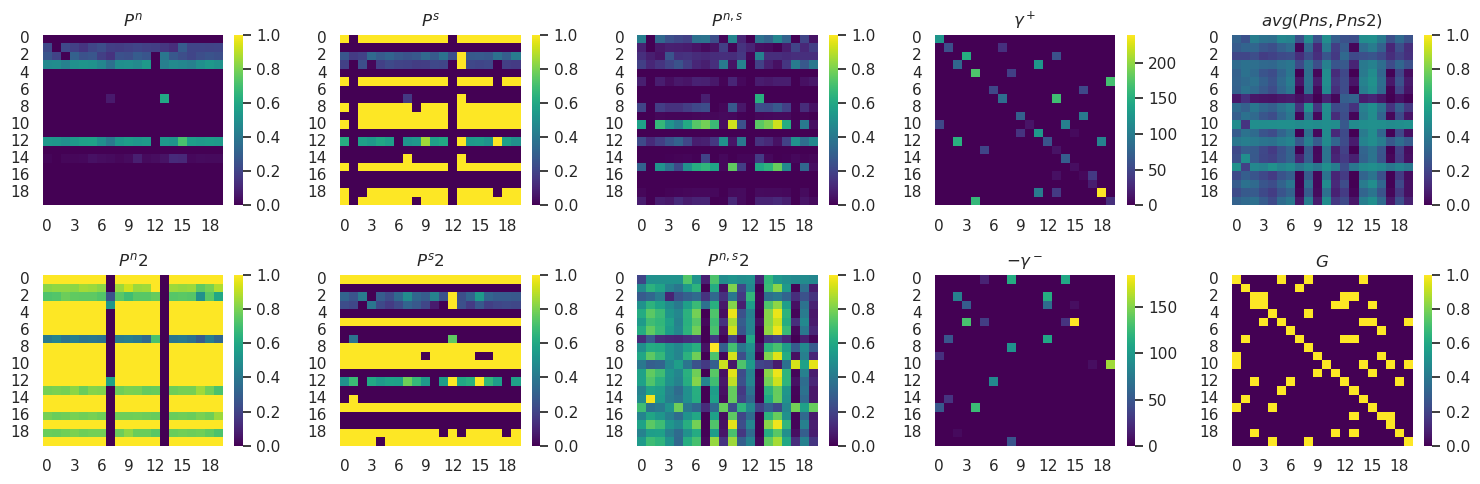

In [944]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# Plot each heatmap
sns.heatmap(Pn, ax=axes[0][0], cmap="viridis", vmin=0, vmax=1)
axes[0][0].set_title("$ P^n $")

sns.heatmap(Ps, ax=axes[0][1], cmap="viridis", vmin=0, vmax=1)
axes[0][1].set_title("$ P^s $")

sns.heatmap(Pns, ax=axes[0][2], cmap="viridis", vmin=0, vmax=1)
axes[0][2].set_title("$ P^{n,s} $")

sns.heatmap(Gamma*(Gamma>0), ax=axes[0][3], cmap="viridis")
axes[0][3].set_title("$ \gamma^+ $")

sns.heatmap(0.5*(Pns + Pns2) , ax=axes[0][4], cmap="viridis", vmin=0, vmax=1)
axes[0][4].set_title("$ avg(Pns , Pns2) $")


sns.heatmap(Pn2, ax=axes[1][0], cmap="viridis", vmin=0, vmax=1)
axes[1][0].set_title("$ P^n2 $")

sns.heatmap(Ps2, ax=axes[1][1], cmap="viridis", vmin=0, vmax=1)
axes[1][1].set_title("$ P^s2 $")

sns.heatmap(Pns2, ax=axes[1][2], cmap="viridis", vmin=0, vmax=1)
axes[1][2].set_title("$ P^{n,s}2 $")

sns.heatmap(-Gamma*(Gamma<0), ax=axes[1][3], cmap="viridis")
axes[1][3].set_title("$ -\gamma^- $")

sns.heatmap(Alpha>0, ax=axes[1][4], cmap="viridis", vmin=0, vmax=1)
axes[1][4].set_title("$ G $")

# Adjust layout
plt.tight_layout()
plt.show()

In [945]:
G = np.double(Alpha > 0)

In [946]:
np.linalg.norm(G - Pn)/n, np.linalg.norm(G - Ps)/n, np.linalg.norm(G - Pns )/n

(0.39987693628693244, 0.6262439165831967, 0.39457436454896044)

(0.0, 20.0)

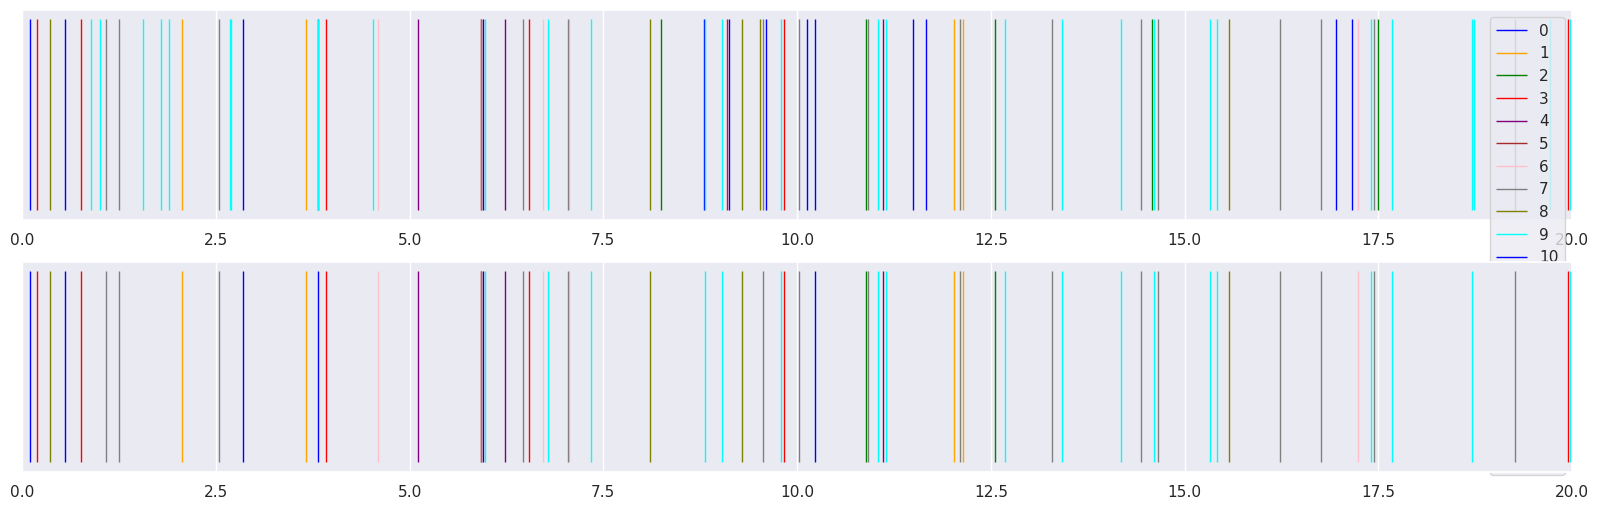

In [953]:
colors = [
    'blue', 'orange', 'green', 'red', 'purple', 
    'brown', 'pink', 'gray', 'olive', 'cyan',
    'blue', 'orange', 'green', 'red', 'purple', 
    'brown', 'pink', 'gray', 'olive', 'cyan'
]

fig, ax = plt.subplots(2,1, figsize=(20, 6))
for i in range(n):
    ax[0].vlines(PHI[i], ymin=0, ymax=1, color=colors[i], linewidth=1, label=f'{i}')  # Vertical spikes
    ax[1].vlines(E_all[i], ymin=0, ymax=1, color=colors[i], linewidth=1, label=f'{i}')  # Vertical spikes
ax[0].set_yticks([])  # Remove y-axis labels
ax[1].set_yticks([])  # Remove y-axis labels
ax[0].legend()
ax[0].set_xlim([0, 20])
ax[1].set_xlim([0, 20])


In [949]:
np.sum(len(E_all[i]) for i in range(n))/np.sum(len(PHI[i]) for i in range(n))

/tmp/ipykernel_31066/471861022.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(len(E_all[i]) for i in range(n))/np.sum(len(PHI[i]) for i in range(n))


0.8573267920172265

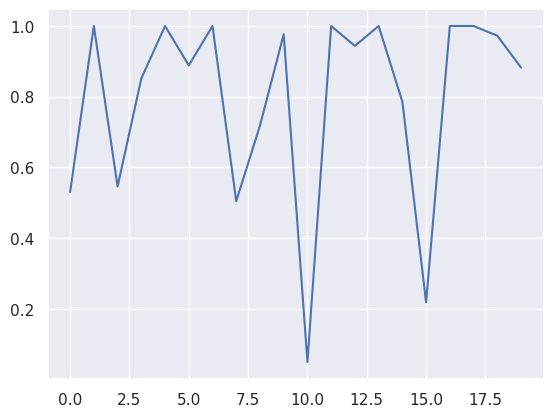

In [950]:
plt.plot([len(E_all[i])/len(PHI[i]) for i in range(n)])
# plt.plot(np.sum(Alpha>0, axis=1))

Text(0.5, 0, '$ \\sum_{j \\in pa_i} \\gamma_{ij} $')

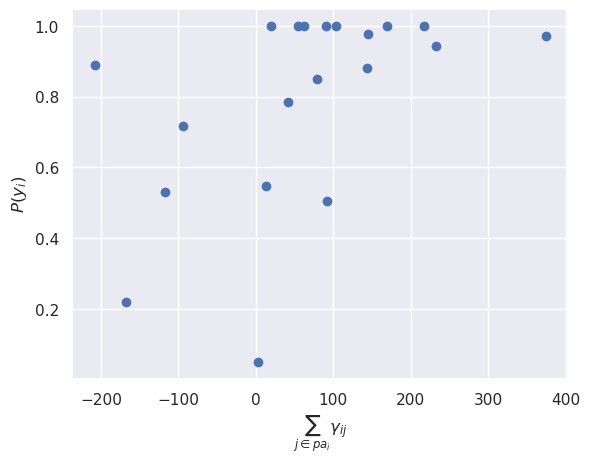

In [951]:
plt.scatter(np.sum(Gamma, axis=1), [len(E_all[i])/len(PHI[i]) for i in range(n)])
plt.ylabel('$ P(y_i) $')
plt.xlabel('$ \sum_{j \in pa_i} \gamma_{ij} $')